## Import packages


In [29]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# data munging tools
import pandas as pd
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## Reading in the data

In [30]:
filename = os.path.join("..", "data", "labelled_data", "fake_or_real_news.csv")

DATA = pd.read_csv(filename, index_col=0)

__Inspect data__

In [31]:
DATA.sample(10)

,title,text,label
5238,Who will Hillary Clinton’s ‘basket of deplorab...,"""To just be grossly generalistic, you could pu...",REAL
595,Koch-backed network aims to spend nearly $1 bi...,— A network of conservative advocacy groups ba...,REAL
3821,Obama’s trip to Ethiopia alarms some human rig...,President Obama embarks on a trip to Africa on...,REAL
7389,Trump’s HUGE Rally Crowds vs HIllary Clinton’s...,Migrant Crisis Disclaimer \nWe here at the Dai...,FAKE
8776,The path to total Dictatorship: America’s Shad...,The path to total Dictatorship: America’s Shad...,FAKE
3517,Footage shows suspects in Brussels attack,"Brussels, Belgium (CNN) In grainy images from ...",REAL
101,Rachel Dolezal has a right to be black (Opinion),"On Monday, Rachel Dolezal, the head of the Spo...",REAL
9831,Debunked: The Photo Of Obama With A Speech Bal...,Email \nIn an age where information can be spr...,FAKE
10057,How the election battle shapes up,"1 Comment on ""How the election battle shapes u...",FAKE
2487,Boehner's preparing to sue Obama again — over ...,It's hard to argue that the existing Deferred ...,REAL


In [32]:
DATA.shape

(6335, 3)

The data has 6335 rows (individual instances of news) and 3 columns. 

<br>
Q: How many examples of each label do we have?

In [33]:
DATA["label"].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

The dataset is almost perfectly balanced. We have a bit more real news than fake news, but otherwise it is almost 50/50.

## Create balanced data

We always want the classes to be balanced, otherwise the classifier will weight the most common type of data more. Hence, we want balanced data in order for the classifier to actually learn patterns instead of relying on the most common data type.

We can use the function ```balance``` to create a more even dataset.

In [34]:
DATA_balanced = clf.balance(DATA, 1000) # we are taking 1000 of each class in the data (real and fake news)
# The balance() function uses a random sampling process which means that we get a difference sample of news each time

In [35]:
DATA_balanced.shape

(2000, 3)

Now we have 1000 of each data type - hence, 1000 real news and 1000 fake news.

In [36]:
DATA_balanced["label"].value_counts()

REAL    1000
FAKE    1000
Name: label, dtype: int64

<br>

What do the label counts look like now?

In [37]:
DATA_balanced["label"].value_counts()

REAL    1000
FAKE    1000
Name: label, dtype: int64

<br>

Let's now create new variables called ```texts``` and ```lables```, taking the data out of the dataframe so that we can mess around with them.

In [38]:
texts = DATA_balanced["text"]
labels = DATA_balanced["label"]

In [39]:
texts[:10]
labels[:10]

0    FAKE
1    FAKE
2    FAKE
3    FAKE
4    FAKE
5    FAKE
6    FAKE
7    FAKE
8    FAKE
9    FAKE
Name: label, dtype: object

# Train-test split

Now we take the data and the labels and create a training and test set. 

I've included most of the 'hard work' for you here already, because these are long cells which might be easy to mess up while live-coding.

Instead, we'll discuss what's happening. If you have questions, don't be shy!

In [40]:
X_train, X_test, y_train, y_test = train_test_split(texts,           # texts for the model
                                                    labels,          # classification labels
                                                    test_size=0.2,   # create an 80/20 split - rather than defining an integer value, we are specifying a percentage value (0.2 = 20% of the data)
                                                    random_state=42) # random state for reproducibility

# Vectorizing and Feature Extraction

Vectorization. What is it and why are all the cool kids talking about it?

Essentially, vectorization is the process whereby textual or visual data is 'transformed' into some kind of numerical representation. One of the easiest ways to do this is to simple count how often individual features appear in a document.

Take the following text: 
<br><br>
<i>My father’s family name being Pirrip, and my Christian name Philip, my infant tongue could make of both names nothing longer or more explicit than Pip. So, I called myself Pip, and came to be called Pip.</i>
<br>

We can convert this into the following vector

| and | be | being | both | called | came | christian | could | explicit | family | father | i | infant | longer | make | more | my | myself | name | names | nothing | of | or | philip | pip | pirrip | s | so | than | to | tongue|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |  --- |
| 2 | 1 | 1 | 1 | 2 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 2 | 1 | 1 | 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 | 1 | 1 |

<br>
Our textual data is hence reduced to a jumbled-up 'vector' of numbers, known somewhat quaintly as a <i>bag-of-words</i>.
<br>
<br>
To do this in practice, we first need to create a vectorizer. 

Tfidf vectors tend to be better for training classifiers. Why might that be?

__Create vectorizer object__

scikit-learn has its own vectorizer function called ```TfidfVectorizer()```that creates vectors. This is when we start to manually tweek the model to get the best results (parameters that best fit the data).

When using this function we are creating a vectorizer and taking these inputs: <br>

```ngram_range```: combinations of tokens that appear in the data. A unigram is one word, while a bigram is two words (e.g. names like "Donald Trump"). Below, we are saying that we want both unigrams (1) and bigrams (2). <br>

```lowercase```: specifying whether we want lowercase letters or not. <br>

```max_df```: the maximum number of documents that a word should be allowed to appear in. If a word appears in more than 95% of the documents, then we remove it. Hence, this is used to remove very frequent word. This is instead of using a stopword dictionary, becasue these are often too simplisitc and biased in terms of what is included and not. We could have included a stopword list instead of doing these thresholds by specifying ```stopwords="english``` wich takes the inbuilt stopword list in sklearn, but using these thresholds is more generalizable than using a stopword dictionary <br>

```min_df```: the minimum number of documents that a would should appear in in order to be included. <br>

```max_features```: the maximum number of features that we want to use. If we do not specify this threshold we are going to end up with a huge list of ngrams (features), which is why we choose to work with only a subset of the most important features. 


NB! We could have used a lot of preprocessing steps, but these are what we are working with in this example.


Running the code below means that we end up with an object called a ```vectorizer``` which looks for bigrams and unigrams, lowercases the text, gets rid of common and infrequent word, and is trained on the used dataset to find the ngrams.  

In [41]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),     # unigrams and bigrams (1 word and 2 word units)
                             lowercase =  True,       # why use lowercase?
                             max_df = 0.95,           # remove very common words
                             min_df = 0.05,           # remove very rare words
                             max_features = 500)      # keep only top 500 features

Hence, now we have defined/initialized our vectorizer object. These parameters might not be the most optimal, but we can change them depending on the results we get later. 

We have used the ```TfidVectorizer``` but we could also have used to ```countVectorizer```

This vectorizer is then used to turn all of our documents into a vector of numbers, instead of text. Hence, we fit the vectorizer to our training data. When fitting the vectorizer to the data, we transform the data to a feature representation (intermediate representation). 

In [42]:
# First we do it for our training data...
X_train_feats = vectorizer.fit_transform(X_train) # fitting the vectorizer model to the training data that is then transformed into a feature representation. Hence, we get a list of vector representaions of the features that appear in the training data
#... then we do it for our test data
X_test_feats = vectorizer.transform(X_test)
# We can also create a list of the feature names. 
feature_names = vectorizer.get_feature_names() # getting the names of the features whichi corresponds to the unigrams and bigrams that the vectorizer has extracted from the data

What are we doing when we are fitting and transforming?
- Fitting: taking the data and putting it into a feature representation. Hence, we fill the spaces of the vectorizer with tthe training data. 
- Transform: changing the data we have so that it looks like the shape of the vectorizer we have (i.e. a feature representation). 


What we have done now is taking our dataset and the vectorizer object, fed and transformed the training data to get features, transformed the test data, and now we have the features names which we can now inspect. 

## Classifying and predicting

Now we need to fit a logistic regression model to the data.

We now have to 'fit' the classifier to our data. This means that the classifier takes our data and finds correlations between features and labels.

These correlations are then the *model* that the classifier learns about our data. This model can then be used to predict the label for new, unseen data.

In [43]:
# Here we are fitting a logistic regression model to the extracted features from the data and the labels for those features
classifier = LogisticRegression(random_state=42).fit(X_train_feats, y_train)

Q: How do we use the classifier to make predictions?

In [44]:
# Predicting the test features - for each data point in the test data
y_pred = classifier.predict(X_test_feats) 

Q: What are the predictions for the first 20 examples of the test data?

In [45]:
# Examining the predictions that the model has made for the first 20 news
print(y_pred[0:20])

['REAL' 'FAKE' 'REAL' 'FAKE' 'REAL' 'REAL' 'FAKE' 'REAL' 'FAKE' 'REAL'
 'FAKE' 'FAKE' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'REAL']


We can also inspect the model, in order to see which features are most informative when trying to predict a label. 

To do this, we can use the ```show_features``` function that I defined earlier - how convenient!

Q: What are the most informative features? Use ```show_features```to find out!

In [46]:
# Now we get the weights and coeffficient for the unigrams and bigrams which most closely correspond to each class (fake and real)
clf.show_features(vectorizer, y_train, classifier, n=20)
# Hence, these are the features that mostly correspnd to each class
# We can see a very clear distribution - real news focus on reporting the election campaign, while fake news focus heavily on the tabloid aspects of hte news (hillary, fbi, russia) 

FAKE				REAL

-2.9780	hillary        		2.5194	but            
-2.8956	october        		2.0789	sanders        
-2.1252	election       		1.9963	republican     
-2.1119	by             		1.9796	tax            
-1.5837	your           		1.9631	cruz           
-1.5213	us             		1.8650	that           
-1.5097	com            		1.7671	candidates     
-1.4217	fbi            		1.7355	debate         
-1.3862	november       		1.7327	gop            
-1.3715	email          		1.6828	state          
-1.3279	the us         		1.6495	sen            
-1.2822	russia         		1.6391	conservative   
-1.2676	hillary clinton		1.6077	rubio          
-1.2397	this           		1.5743	islamic        
-1.2352	being          		1.5499	fox            
-1.2042	anti           		1.5443	department     
-1.2038	you            		1.5243	he             
-1.1866	just           		1.5124	says           
-1.0828	however        		1.4651	republicans    


^The values we get here are the coefficients (weights) for the features that the model has learned.

We can see that words like "you", "but", "by" are in there, which means that we should maybe change the max threshold for when to exlude words that appear frequently. 

It seems that the classifier is performing in a way that we would expect it to whihc is good

## Evaluate

The computer has now learned a model of how our data behaves. Well done, computer! But is it accurate?

Q: How do we measure accuracy?

<img src="../img/confusionMatrix.jpg">

Thankfully, libraries like ```sklearn``` come with a range of tools that are useful for evaluating models.

One way to do this, is to use a confusion matrix, similar to what you see above.

Q: What should go in the argument called ```labels```?

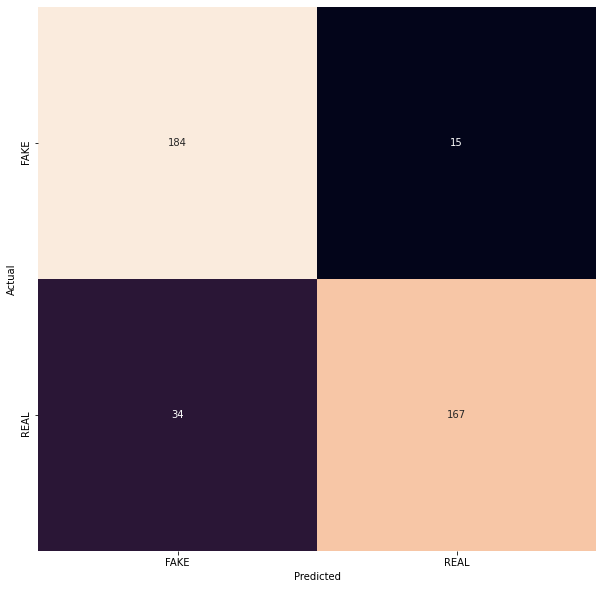

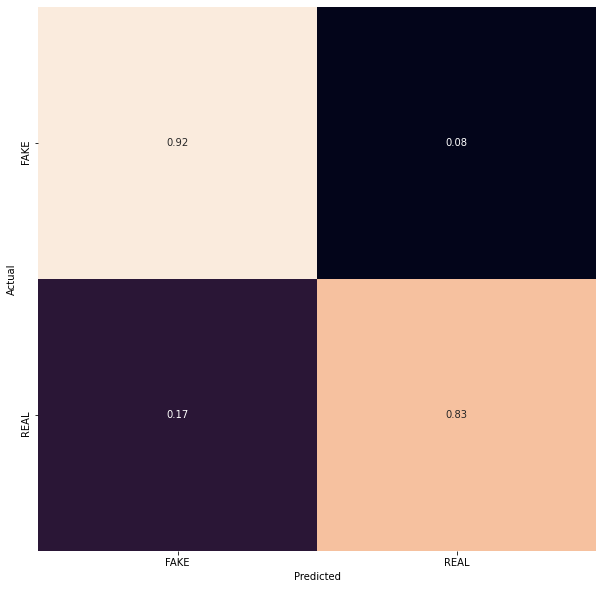

In [51]:
# Here we take the actual test labels and the predicted test labels and we plot how well the nodel is performing.
clf.plot_cm(y_test, y_pred, normalized=False) # showing actual numbers
clf.plot_cm(y_test, y_pred, normalized=True) # showing percentage

We can see that the model is performing quite well. <br>
Black: misclassifications. 

We can also do some quick calculations, in order to assess just how well our model performs.

In [48]:
# Now we get some actual report of the model's performance
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

        FAKE       0.84      0.92      0.88       199
        REAL       0.92      0.83      0.87       201

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



__Conclusion:__ the model performs pretty well in classifying real and fake news (it is correct around 85% of the time)

__Potential problems with this classifier?__
1. This performance is dependent on the training data that we have trained the model on on the test data we test it on. Because we are taking a random sample of the real and fake news, how the model performs is dependent on this sample it has been trained and tested on. Hence, the performance of the model will depend on the split that we have made, which means that we cannot really generalize these results. The performance of the model also depends on whether we focus on unigrams, bigrams, or trigams etc. because this impacts how well the model performs. To solve this we can perform cross validation - this will give us a measure of how well the model performs in general and not just on a particular sample of the data. 

## Cross validation and further evaluation

One thing we can't be sure of is that our model performance is simply related to how the train-test split is made.

To try to mitigate this, we can perform cross-validation, in order to test a number of different train-test splits and finding the average scores.

When performing cross-validation, we crate many different training and test splits and come up with an average of those splits, and then test the model on that average. 

Let's do this on the full dataset

In [49]:
# We run the vectorizer object (i.e. fit the model) on the entire data
X_vect = vectorizer.fit_transform(texts)
# X_vect is the vectorized representations on the entire dataset.

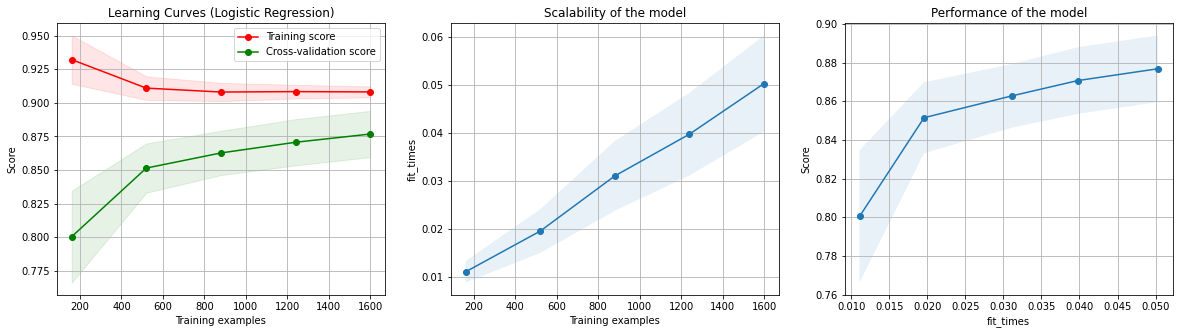

In [50]:
title = "Learning Curves (Logistic Regression)"

# Using shufflesplit() function to create 100 different samples from the entire data - hence, we iterate over the data 100 times and pick out 80% for training and 20% for testing
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# We create an estimator object (our model) 
model = LogisticRegression(random_state=42)

# Plotting the learning curves for the model
clf.plot_learning_curve(model, title, X_vect, labels, cv=cv, n_jobs=4)
# n_jobs is the number of CPU cores

These visualizations allow us to estimate the performance of the model on average and not just on a single training split. 

The first plot is probably the most interesting. Some terminology:

- If two curves are "close to each other" and both of them but have a low score, the model suffers from an underfitting problem (High Bias). Hence, if the two curves are close togehter, then we are underfitting. 

- If there are large gaps between two curves, then the model suffer from an overfitting problem (High Variance). Hence, if the curves are far from each other we are overfitting - a lot of variance in the test data cannot be predicted based on the training data. If this is the case, we need to go back and redefine the classifier. 

- The first plot: This is the learning curve of the model. It shows how well the model is performing over time. 
- The second plot shows the times required by the models to train with various sizes of training dataset. Hence, as we increase the numberof training samples, the time it takes to calculate the model will increase. 
- The third plot show how much time was required to train the models for each training sizes. Hence, the more time spent on training produces higher accuracy. 